In [118]:
pip install openpyxl==3.0.9

In [119]:
#Upload file
import io
import pandas as pd
import datetime
import numpy as np
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

Saving Bonds Chosen.xlsx to Bonds Chosen.xlsx


In [133]:
#Load Bond data into data frame

data = io.BytesIO(uploaded['Bonds Chosen.xlsx'])
bonds = pd.read_excel(data, sheet_name = 'Sheet1', header = 0)

#Extract dates
date_and_time = bonds.columns.tolist()[5:]

dates = []
#Modify names of dates
for i in date_and_time:
  dates.append(i.date())

res = dict(zip(date_and_time, dates))
bonds = bonds.rename(columns = res)

bonds

,Name,Coupon,ISIN,Issue Date,Maturity Date,2022-01-10,2022-01-11,2022-01-12,2022-01-13,2022-01-14,2022-01-17,2022-01-18,2022-01-19,2022-01-20,2022-01-21
0,CDA 2022,0.0050,CA135087G328,2016-10-10,2022-02-28,100.040,100.03,100.030,100.030,100.020,100.02,100.000,100.000,100.000,100.010
1,CANADA 20/22,0.0025,CA135087L286,2020-05-03,2022-07-31,99.800,99.79,99.780,99.770,99.760,99.72,99.700,99.700,99.720,99.740
2,CANADA 20/23,0.0025,CA135087L773,2020-10-25,2023-01-31,99.310,99.26,99.290,99.280,99.260,99.18,99.120,99.100,99.150,99.200
3,CANADA 21/23,0.0025,CA135087M359,2021-05-13,2023-07-31,98.808,98.80,98.781,98.763,98.736,98.61,98.553,98.549,98.558,98.611
4,CANADA 21/24,0.0075,CA135087M920,2021-10-21,2024-01-31,99.200,99.20,99.160,99.130,99.090,98.92,98.840,98.840,98.830,98.900
5,CDA 19/24,0.0150,CA135087J967,2019-04-04,2024-08-31,100.560,100.63,100.620,100.580,100.520,100.29,100.210,100.150,100.170,100.270
6,CANADA 19/25,0.0125,CA135087K528,2019-10-10,2025-02-28,99.640,99.67,99.610,99.590,99.490,99.25,99.120,99.110,99.100,99.260
7,CANADA 20/25,0.0050,CA135087K940,2020-04-02,2025-08-31,96.660,96.72,96.770,96.770,96.680,96.43,96.260,96.150,96.190,96.310
8,CANADA 20/26,0.0025,CA135087L518,2020-10-08,2026-02-28,95.110,95.17,95.120,95.140,95.040,94.75,94.530,94.500,94.520,94.700
9,CANADA 21/26,0.0100,CA135087L930,2021-04-15,2026-08-31,97.660,97.70,97.670,97.695,97.585,97.24,97.020,96.960,97.000,97.225


# Question 4a

In [134]:
#A helper function to calculate ytm
def f(ytm, dirty_price, coupon_rate, coupon_year):
  pv_notional = np.exp(-ytm*coupon_year[-1])*100
  return dirty_price - np.sum(np.exp(-ytm*coupon_year)*coupon_rate*100/2) - pv_notional

In [135]:
#(day, yeild curve points)
ytm = np.zeros((10,10))

date_in_years = np.zeros(10)
#i represents the ith bond in the list
for day in range(10):
  for i in range(10):
    #Find dates when coupons are paid
    maturity_month = ((bonds['Maturity Date'][i].year - dates[day].year ) * 12 
                      + (bonds['Maturity Date'][i].month - dates[day].month))

    date_in_years[i] = maturity_month/12

    coupon_year = list(range(maturity_month%6, maturity_month, 6))
    coupon_year.append(maturity_month)
    coupon_year = np.array(coupon_year)/12

    #Calculate Accured interest
    years_from_coupon = 0.5 - coupon_year[0]
    acc_interest = bonds['Coupon'][i]*100*years_from_coupon

    #Calculate dirty price
    dirty_price = bonds[dates[day]][i] + acc_interest
    
    ytm[day, i] = optimize.newton(f, 0.01, args = (dirty_price, bonds['Coupon'][i], coupon_year))

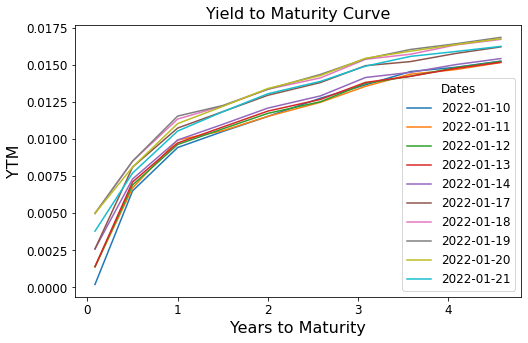

In [136]:
#Plotting
plt.figure(figsize = (8, 5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', labelsize= 22)
  
plt.plot(date_in_years, ytm.T)


plt.title("Yield to Maturity Curve",fontsize=16)
plt.xlabel('Years to Maturity',fontsize=16)
plt.ylabel("YTM",fontsize=16)
plt.legend(dates, title = "Dates")
plt.show()

# Question 4b

In [137]:
#(day, spot curve points)
spot_curve = np.zeros((10,10))

date_in_years = np.zeros(10)
#i represents the ith bond in the list
for day in range(10):
  for i in range(10):
    #Find dates when coupons are paid
    maturity_month = ((bonds['Maturity Date'][i].year - dates[day].year ) * 12 
                      + (bonds['Maturity Date'][i].month - dates[day].month))

    date_in_years[i] = maturity_month/12

    coupon_year = list(range(maturity_month%6, maturity_month, 6))
    coupon_year.append(maturity_month)
    coupon_year = np.array(coupon_year)/12

    #Calculate Accured interest
    years_from_coupon = 0.5 - coupon_year[0]
    acc_interest = bonds['Coupon'][i]*100*years_from_coupon

    #Calculate dirty price
    dirty_price = bonds[dates[day]][i] + acc_interest

    P = dirty_price

    count = 0

    for j in range(len(coupon_year)-1):
      
      #Find which discount rate to use
      #Bonds ordered in increasing maturity. If coupon date is > t_i, go to t_{i+1}
      while coupon_year[j] > date_in_years[count]:
        count += 1

      P = P - bonds['Coupon'][i]*100/2*np.exp(-spot_curve[day, count]*coupon_year[j])
    
    final_pay = 100 + bonds['Coupon'][i]*100/2
    spot_curve[day, i] = -np.log(P/final_pay)/date_in_years[i]

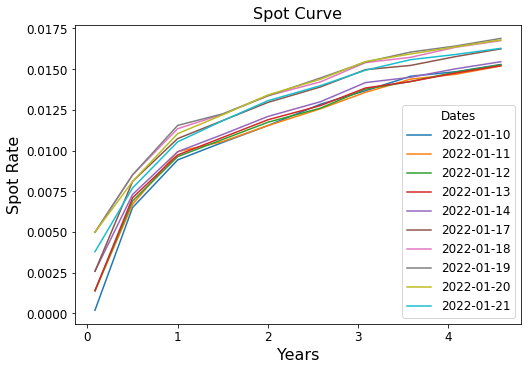

In [138]:
#Plotting
plt.figure(figsize = (8, 5.5))
plt.plot(date_in_years, spot_curve.T)

plt.title("Spot Curve",fontsize=16)
plt.xlabel('Years',fontsize=16)
plt.ylabel("Spot Rate",fontsize=16)
plt.legend(dates, title = "Dates")
plt.show()

# Question 4c
Notes: Uses code from 4b

In [139]:
#(day, spot rate)
r_t = interpolate.interp1d(date_in_years, spot_curve, fill_value = 'extrapolate', assume_sorted= True)

years = np.arange(1,6)
spot_at_years = r_t(years)

#(days, foward rate points)
forward_rate = np.zeros((10, 4))

for i in range(0,4):
  forward_rate[:,i] = (spot_at_years[:,1+i]*(i+2)- spot_at_years[:,0])/(1+i)


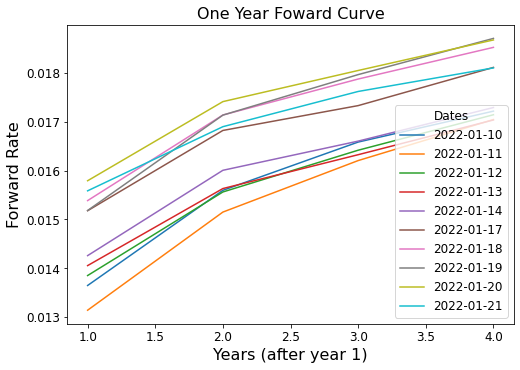

In [140]:
#Plotting
plt.figure(figsize = (8, 5.5))
plt.plot(np.arange(1,5), forward_rate.T)

plt.title("One Year Foward Curve",fontsize=16)
plt.xlabel('Years (after year 1)',fontsize=16)
plt.ylabel("Forward Rate",fontsize=16)
plt.legend(dates, title = "Dates", loc = 'lower right')
plt.show()

# Question 5

In [141]:
def cov_matrix(X):
  n_sample, n = X.shape

  #X[:,i] is X_i
  E_X = np.mean(X, axis = 0)
  Cov_X = np.zeros((n,n))

  for i in range(n):
    for j in range(n):
      Cov_X[i,j] = 1/(n_sample-1)*np.sum((X[:,i]-E_X[i])*(X[:,j]-E_X[j]))

  return Cov_X

Eigenvalues and Eigenvectors for yeild curve

In [142]:
ytm_function = interpolate.interp1d(date_in_years, ytm, fill_value = 'extrapolate', assume_sorted= True)

#(day, ytm)

yeilds = ytm_function(np.arange(1,6))

X = np.log(yeilds[1:,:]/yeilds[:-1,:])

print(X.shape)
Cov_X = cov_matrix(X)

values, vectors = np.linalg.eigh(Cov_X)

print(Cov_X.round(6))

print(values.round(11))
print(vectors.round(6))

(9, 5)
[[0.002054 0.000823 0.000765 0.000761 0.000861]
 [0.000823 0.000688 0.000645 0.000575 0.000577]
 [0.000765 0.000645 0.000638 0.000575 0.000572]
 [0.000761 0.000575 0.000575 0.00055  0.00054 ]
 [0.000861 0.000577 0.000572 0.00054  0.000555]]
[4.94983000e-06 9.15411000e-06 4.69985800e-05 6.08096730e-04
 3.81624038e-03]
[[-0.106597 -0.01453  -0.063608 -0.728577 -0.673465]
 [ 0.267496 -0.291078 -0.737321  0.388251 -0.386444]
 [-0.618637  0.547374 -0.023019  0.424096 -0.370517]
 [-0.181791 -0.665668  0.547779  0.316788 -0.351313]
 [ 0.708041  0.415127  0.389513  0.195512 -0.369327]]


Eigenvalues and Eigenvectors for forward curve

In [143]:
#(day, ytm)
X_forward= np.log(forward_rate[1:,:]/forward_rate[:-1,:])

Cov_forward = cov_matrix(X_forward)
values, vectors = np.linalg.eigh(Cov_forward)


print(Cov_forward.round(6))

print(values.round(10))
print(vectors.round(6))

[[0.001083 0.000766 0.000546 0.000436]
 [0.000766 0.000675 0.000545 0.000494]
 [0.000546 0.000545 0.000505 0.000467]
 [0.000436 0.000494 0.000467 0.000481]]
[1.2649300e-05 1.7630200e-05 3.3239540e-04 2.3816733e-03]
[[-0.359463  0.043342 -0.694287 -0.621991]
 [ 0.825549  0.189669  0.057756 -0.528355]
 [-0.119057 -0.801752  0.397189 -0.430419]
 [-0.418427  0.565103  0.597386 -0.385625]]
